In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import hvplot.xarray
import cartopy.crs as ccrs
from datetime import datetime as dt
plt.close('all')

In [2]:
# Loading in dataset: (duplicate cell for multiple datasets, and change variable name)

path = 'H:\\Summer24-25\\' ##### enter file path here ---> double slashes or change direction eg. \ --> \\ or / #####
name = 'o3_Amon_CESM2-WACCM_ssp126*.nc' ##### enter file name here --> use * if need multiple files/versions per dataset #####
ds = xr.open_mfdataset(path+name, parallel=True)

if ds.plev.attrs['units'] == 'Pa':
    ds['plev'] = ds.plev / 100
    ds.plev.attrs['axis'] = 'Z'
    ds.plev.attrs['positive'] = 'down'
    ds.plev.attrs['standard_name'] = 'air_pressure'
    ds.plev.attrs['title'] = 'pressure'
    ds.plev.attrs['type'] = 'double'
    ds.plev.attrs['units'] = 'hPa'

ds.plev

C:\Python312\Lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'o3' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    5.,    1.])
Coordinates:
  * plev     (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
Attributes:
    axis:           Z
    positive:       down
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          hPa

# HVPLOTS

In [5]:
import hvplot.xarray # **this cell is important**
# Use isel (index select) to plot graph using index of coordinates
plt1 = ds.HNO3.isel(time=0, lev=-9).hvplot(geo=True) # plot at first time and pressure level indexes

plt2 = ds.CL.isel(time=0, lev=-4).hvplot(
    'lon', 'lat', projection=ccrs.PlateCarree(), project=True,
    global_extent=True, cmap='twilight_shifted', coastline=True
).opts(tools=["hover"], default_tools=[])
plt2
# plt1 + plt2

:Overlay
   .Image.I     :Image   [lon,lat]   (CL concentration)
   .Coastline.I :Feature   [Longitude,Latitude]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
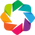

:DynamicMap   [time]
   :Overlay
      .Image.I     :Image   [lon,lat]   (o3)
      .Coastline.I :Feature   [Longitude,Latitude]

In [6]:
import holoviews as hv
from holoviews import opts
from holoviews import streams
hv.extension('bokeh')

hv.output(widget_location='bottom')
data = ds.o3.mean(dim='plev').isel(time=slice(0,36,1))
# norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
data.hvplot(
    'lon', 'lat', projection=ccrs.Orthographic(0,-90), global_extent=False, project=True, 
    cmap='turbo', coastline=True, size=500, clim=(1.1*10**-6, 2.2*10**-6)
).opts(default_tools=[])


In [7]:
# ds.o3.sel(plev=20000).sort_values('month').hvplot.quadmesh(x='lat', y='lon', alpha=0.2)
ds.o3.sel(plev=20000)[::2,::2].isel(time=slice(6,25,6)).hvplot(col='time', colorbar=False, clim=(10**-8, 5*10**-7))

:GridSpace   [time]
   :Image   [lon,lat]   (Mole Fraction of O3)

In [8]:
path = hv.Path([])
freehand = streams.FreehandDraw(source=path, num_objects=6,
                                styles={'line_color':'yellow'})

path.opts(
    opts.Path(active_tools=['freehand_draw'], height=1000, line_width=20, width=2000))
hvplot.show(path)

Launching server at http://localhost:56427


In [10]:
data = ds.o3.sel(plev=20000).isel(time=slice(0,12*4,1))[2::,2::]
# norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
x = data.hvplot(
    'lon', 'lat', global_extent=False, project=True, geo=True, # projection=ccrs.Orthographic(0,-90),
    cmap='turbo', clim=(10**-8, 5*10**-7), coastline=True, tiles=True, width=1000, height=1000
).opts(tools=['hover'], default_tools=[])

hvplot.show(x)

Launching server at http://localhost:56526


# Matplotlib

In [3]:
%matplotlib module://matplotlib_inline.backend_inline

In [4]:
%matplotlib qt

In [6]:
from mpl_interactions import ioff, panhandler, zoom_factory

fig, ax = plt.subplots()
ds.o3.isel(time=0, plev=9).plot(ax=ax)
ax.grid(c='w', ls='--')
disconnect_zoom = zoom_factory(ax)
pan_handler = panhandler(fig)
display(fig.canvas)
plt.show()

In [53]:
init_plev = 200
init_time = 0
fig,ax = plt.subplots()
graph = ax.imshow(ds.o3.isel(time=init_time).sel(plev=init_plev))
graph.set_data(ds.o3.isel(time=0).sel(plev=100))
fig.canvas.draw_idle()

In [12]:
## PCOLORMESH ##

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider

init_plev = 200
init_time = 0
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.Orthographic(central_latitude=-90))
ax.coastlines()
ax.set_global()
date = dt.strptime(str(ds.time[init_time].values), '%Y-%m-%d %H:%M:%S')
ax.set_title('Date: %s' %date.strftime("%Y %B"))
graph = ds.o3.isel(time=init_time).sel(plev=init_plev).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

fig.subplots_adjust(left=0.25, bottom=0.25)

# horizontal slider --> time
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax=axtime, label='Time (Month)', valmin=0, valmax=24, valstep=1, valinit=init_time,)

# vertical slider -> plev
axplev = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
plev_slider = Slider(ax=axplev, label='Pressure Level (hPa)', valmin=70, valmax=400, 
                     valstep=ds.plev, valinit=init_plev, orientation="vertical",)

def update(val):
    graph.set_array(ds.o3.isel(time=time_slider.val).sel(plev=plev_slider.val))
    date = dt.strptime(str(ds.time[time_slider.val].values), '%Y-%m-%d %H:%M:%S')
    ax.set_title('Date: %s' %date.strftime("%Y %B"))
    # fig.canvas.draw_idle()

# register the update function with each slider
time_slider.on_changed(update)
plev_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    time_slider.reset()
    plev_slider.reset()
    
button.on_clicked(reset)

plt.show()

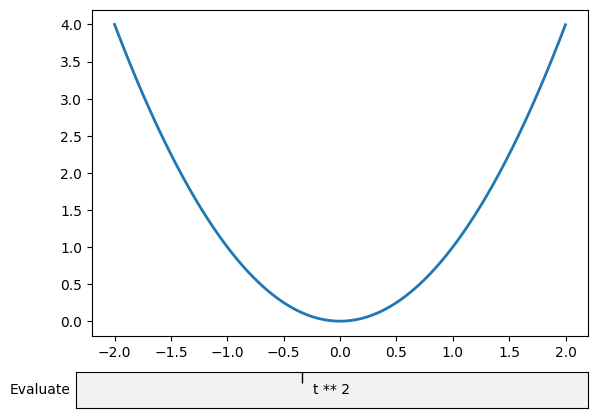

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import TextBox

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

t = np.arange(-2.0, 2.0, 0.001)
l, = ax.plot(t, np.zeros_like(t), lw=2)


def submit(expression):
    """
    Update the plotted function to the new math *expression*.

    *expression* is a string using "t" as its independent variable, e.g.
    "t ** 3".
    """
    ydata = eval(expression, {'np': np}, {'t': t})
    l.set_ydata(ydata)
    ax.relim()
    ax.autoscale_view()
    plt.draw()


axbox = fig.add_axes([0.1, 0.05, 0.8, 0.075])
text_box = TextBox(axbox, "Evaluate", textalignment="center")
text_box.on_submit(submit)
text_box.set_val("t ** 2")  # Trigger `submit` with the initial string.

plt.show()

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
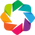

Row(sizing_mode='stretch_width')
    [0] HoloViews(DynamicMap, height=250, sizing_mode='stretch_width', widgets={'amplitude': LiteralInput...})
    [1] WidgetBox(align=('end', 'start'))
        [0] FloatSlider(end=10, name='frequency', start=0.1, value=5)
        [1] LiteralInput(name='amplitude', type=(<class 'float'>, ..., value=1.0)
        [2] RadioButtonGroup(name='function', options=[np.str_('sin'), ...], value=np.str_('sin'))

In [9]:
import panel as pn

hv.extension("bokeh")

import pandas as pd
import hvplot.pandas
import holoviews.plotting.bokeh
import numpy as np

def sine(frequency=1.0, amplitude=1.0, function='sin'):
    xs = np.arange(200)/200*20.0
    ys = amplitude*getattr(np, function)(frequency*xs)
    return pd.DataFrame(dict(y=ys), index=xs).hvplot(height=250, responsive=True)

dmap = hv.DynamicMap(sine, kdims=['frequency', 'amplitude', 'function']).redim.range(
    frequency=(0.1, 10), amplitude=(1, 10)).redim.values(function=['sin', 'cos', 'tan'])

dmap_panel = pn.panel(dmap, height=400, sizing_mode="stretch_width")
dmap_panel

pn.panel(dmap, center=True, widget_layout=pn.Row, widget_location='top_left')
hv_panel = pn.pane.HoloViews(dmap, widgets={
    'amplitude': pn.widgets.LiteralInput(value=1., type=(float, int)),
    'function': pn.widgets.RadioButtonGroup,
    'frequency': {'value': 5}
}).layout

hv_panel